# Homework 7

In [1]:
## Boilerplate instructions for importing NumPy and Matplotlib
# Import NumPy
import numpy as np

# To plot pretty figures, use matplotlib
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

## The next few cells import the second-order filter and the integrator defined in class

In [2]:
class Second_Order_Filter():
    """Class representing a second-order loop filter"""

    def __init__(self, alpha1, alpha2, state=0):
        """Initialize the gains and the state of the filter
        
        Input:
        alpha1 - linear gain
        alpha2 - integrator gain
        state - value helpd by integrator (optional, default: 0)
        """
        self.alpha1 = alpha1
        self.alpha2 = alpha2
        self.state = state

    def __call__(self, d_n):
        """invoke the filter
        
        Input:
        d_n - single sample, representing error

        Returns:
        filtered sample; type is the same as the input
        """
        out = self.alpha1 * d_n + self.state
        self.state += self.alpha2 * d_n  # update state
        
        return out

    # below, we check that 0 <= alpha2 < alpha1 < 1
    @property
    def alpha1(self):
        return self._alpha1

    @alpha1.setter
    def alpha1(self, new_val):
        if new_val < 1 and new_val > 0:
            self._alpha1 = new_val
        else:
            raise ValueError("alpha1 = {:} can make PLL unstable".format(new_val))

    @property
    def alpha2(self):
        return self._alpha2

    @alpha2.setter
    def alpha2(self, new_val):
        if new_val < self._alpha1 and new_val > 0:
            self._alpha2 = new_val
        else:
            raise ValueError("alpha2 = {:} can make PLL unstable".format(new_val))

    @property
    def state(self):
        return self._state

    @state.setter
    def state(self, new_val):
        self._state = new_val

    @property
    def damping_factor(self):
        return self.alpha1 / 2 / np.sqrt(self.alpha2) 

In [3]:
class Integrator():
    """Class representing an integrator"""

    def __init__(self, state=0):
        self.state = state

    def __call__(self, x_n):
        "Compute the output from the integrator"
        out = self.state
        self.state += x_n

        return out

    @property
    def state(self):
        return self._state

    @state.setter
    def state(self, new_val):
        self._state = new_val

## Tracking Loop for Complex Amplitude

In class, we derived and demonstrated a tracking loop for phase
and frequency and a second one for amplitude. In essence, these
two loops together track amplitude and phase variation in polar
coordinates.

It should be possible to track complex amplitude (in cartesian
form) with a single tracking loop. This loop should be similar to
the amplitude tracking loops we discussed in class, except
* amplitude and gain $\gamma$ will be complex valued,
* the loop should be of second order, i.e., the lop filter contains a proportional and an integrating element.

1. Describe the modifications that are needed to adapt the "phase rotation" and "phase detector" for use with complex amplitudes. In other words, how are the estimated corrections applied? And, how is the error that is input to the loop filter measured? 
2. Write Python functions to implement these two blocks.
3. Demonstrate that your tracking loop works as expected by testing them with

    a. an input signal that has an amplitude and phase offset,  
    b. an input signal that has a frequency offset in addition to the amplitude and frequency offset.

In either case, verify that the error between the true
instaneous complex amplitude and the estimated amplitude
approaches zero.

4. For each of the two input signals, what does the state on the integrator in the loop filter converge to? Why?
5. Demonstrate a complete synchronization system consiting of initial acquisition using a preamble in combination with tracking with the PLL above? How do the initial estimates inform the initial state of the integrators in the PLL?

**Answer:**

In this solution, the output from the tracking loop is supposed to track the instantaneous phasor (i.e., complex amplitude) of the channel. If the matched filter output can be described as
$$
    Z_n = s_n \cdot X + N_n
$$
then the tracking loop output $\hat{X}$ is intended to match $X$.

Therefore, the "phase correction" will divide $Z_n$ by $\hat{X}$ so that the phase and amplitude of signal $s_n$ is correct.

The "phase detector" is a little trickier. The correction $\delta$ that must be added to $\hat{X}$ should satisfy
$$
    \frac{Z_n}{\hat{X} + \delta} = s_n.
$$
Solving for the "error" $\delta$ yields
$$
    \delta = \frac{Z_n - s_n \cdot \hat{X}}{s_n} = \frac{Z_n}{s_n} - \hat{X}.
$$

In [4]:
def correction(Z_n, X_hat):
    """Apply amplitude and phase correction"""
    return Z_n / X_hat

In [5]:
def measure_error(Z_n, s_n, X_hat):
    """Measure the error in X_hat"""
    return Z_n / s_n - X_hat

## Constant Phase and Amplitude Offset

In [62]:
# Parameters
alpha1 = 0.1
alpha2 = 0.004  # damping factor approximately 0.8

SNR_db = 20
SNR = 10**(SNR_db/10)

# for simplicity, we start with a signal of all 1's, i.e., zero phase
N = 200*20
s = np.ones(N, dtype=complex)

# storage for intermediate results
delta = np.zeros_like(s, dtype=complex)    # phasor error
X_hat = np.zeros_like(s, dtype=complex)    # phasor estimate
state_H = np.zeros_like(X_hat)             # state of loop filter
x = np.zeros_like(s)                       # phase rotated input
y = np.zeros_like(s)                       # loop filter output

In [63]:
# define phase error
A = 0.5
phi = np.pi/2
phasor_error = A*np.exp(1j*phi) * np.ones(N)

# instantiate loop filter and integrator
H = Second_Order_Filter(alpha1, alpha2)
S = Integrator(1.+0j)  # must initialize state, zero is no good

# make a received signal
Z = s * phasor_error + A/np.sqrt(2*SNR) * (np.random.randn(N) + 1j * np.random.randn(N))

# run the PLL; intermediate signals are stored for analysis
for n in range(N):
    X_hat[n] = S.state
    x[n] = correction(Z[n], X_hat[n])
    delta[n] = measure_error(Z[n], s[n], X_hat[n])
    y[n] = H(delta[n])
    try:
        state_H[n] = H.state
    except AttributeError:
        pass
    S(y[n])  # pass filter output to integrator, we get the otput via S.state


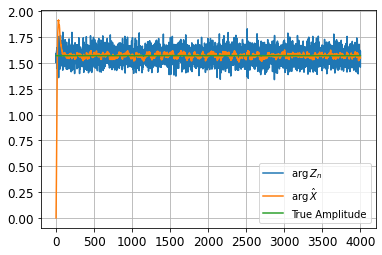

In [64]:
# plot phases
plt.plot(np.angle(Z), label=r'$\arg Z_n$')
plt.plot(np.angle(X_hat), label=r'$\arg \hat{X}$')
plt.plot(np.angle(phasor_error), label="True Amplitude")
#plt.plot(np.angle(delta), label=r'$\arg \delta$')

plt.grid()
plt.legend()

plt.show()

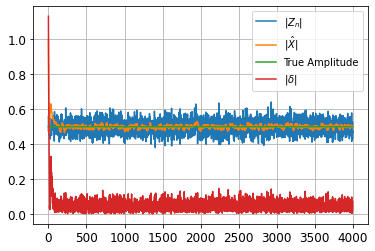

In [65]:
# plot magnitudes
plt.plot(np.abs(Z), label=r'$|Z_n|$')
plt.plot(np.abs(X_hat), label=r'$|\hat{X}|$')
plt.plot(np.abs(phasor_error), label="True Amplitude")

plt.plot(np.abs(delta), label=r'$|\delta|$')

plt.grid()
plt.legend()

plt.show()

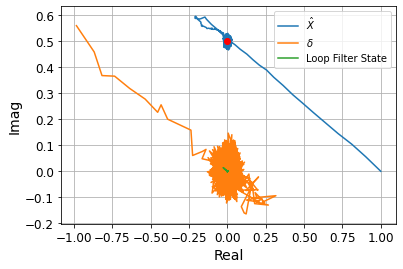

In [66]:
# complex plane
plt.plot(np.real(X_hat), np.imag(X_hat), label="$\hat{X}$")
plt.plot(np.real(delta), np.imag(delta), label="$\delta$")
plt.plot(np.real(state_H), np.imag(state_H), label='Loop Filter State')
plt.plot([A*np.cos(phi)], [A*np.sin(phi)], 'ro')

plt.xlabel('Real')
plt.ylabel('Imag')
plt.grid()
plt.legend()

plt.show()

## Frequency Error

In [67]:
# define phase error
A = 0.5
phi = -np.pi/2
df = np.pi/2/200
phasor_error = A*np.exp(1j*phi) * np.exp(1j*df*np.arange(N))

# instantiate loop filter and integrator
H = Second_Order_Filter(alpha1, alpha2)
S = Integrator(1.+0j)  # must initialize state, zero is no good

# make a received signal
Z = s * phasor_error + 0*A/np.sqrt(2*SNR) * (np.random.randn(N) + 1j * np.random.randn(N))

# run the PLL; intermediate signals are stored for analysis
for n in range(N):
    X_hat[n] = S.state
    x[n] = correction(Z[n], X_hat[n])
    delta[n] = measure_error(Z[n], s[n], X_hat[n])
    y[n] = H(delta[n])
    try:
        state_H[n] = H.state
    except AttributeError:
        pass
    S(y[n])  # pass filter output to integrator, we get the otput via S.state


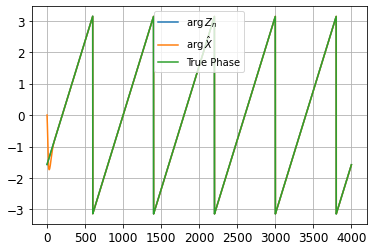

In [68]:
# plot phases
plt.plot(np.angle(Z), label=r'$\arg Z_n$')
plt.plot(np.angle(X_hat), label=r'$\arg \hat{X}$')
plt.plot(np.angle(phasor_error), label="True Phase")
#plt.plot(np.angle(delta), label=r'$\arg \delta$')

plt.grid()
plt.legend()

plt.show()

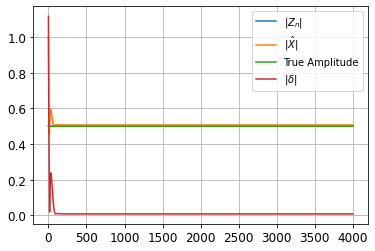

In [69]:
# plot magnitudes
plt.plot(np.abs(Z), label=r'$|Z_n|$')
plt.plot(np.abs(X_hat), label=r'$|\hat{X}|$')
plt.plot(np.abs(phasor_error), label="True Amplitude")

plt.plot(np.abs(delta), label=r'$|\delta|$')

plt.grid()
plt.legend()

plt.show()

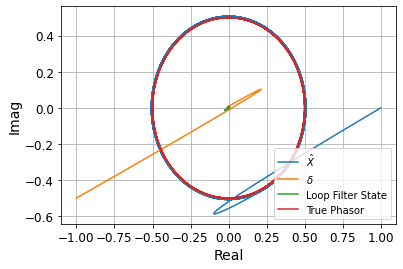

In [70]:
# complex plane
plt.plot(np.real(X_hat), np.imag(X_hat), label="$\hat{X}$")
plt.plot(np.real(delta), np.imag(delta), label="$\delta$")
plt.plot(np.real(state_H), np.imag(state_H), label='Loop Filter State')
plt.plot(np.real(phasor_error), np.imag(phasor_error), label="True Phasor")
#plt.plot([A*np.cos(phi)], [A*np.sin(phi)], 'ro')

plt.xlabel('Real')
plt.ylabel('Imag')
plt.grid()
plt.legend()

plt.show()

**Question:** What is the steady-state value of the integrator in the loop filter.

Assume that for $n$ greater some $N$, the tracker has converged such that $X_n = \hat{X}_n = Ae^{j\phi} \cdot e^{j2\pi f_d n}$. 

Then, the next incoming sample will have phase $X_{n+1}= X_n \cdot e^{j2\pi f_d}$, i.e., the phase will have increased by $2\pif_d$.

On the other hand, the estimator $X_hat$ will be incremented by the value $d_H$ stored in the loop filter. Hence,
$\hat{X}_{n+1} = \hat{X}_n + d_H = X_n + d_H$.

For $X_{n+1} = \hat{X}_{n+1}$, it follows that $X_n \cdot e^{j2\pi f_d} = X_n + d_H$ and, therefore,
$$
    d_H = X_n \cdot (e^{j2\pi f_d} - 1) = (e^{j2\pi f_d} - 1)\cdot Ae^{j\phi} \cdot e^{j2\pi f_d n}.
$$

So, if $f_d=0$, then $d_H$ will converge to zero. However, if $f_d \neq 0$ then $d_H$ does not converge to a constant. Instead it will converge to a complex exponential with frequency $f_d$. Note that the magnitude will be small if $f_d$ is small, since $e^{j2\pi f_d} - 1 \approx j\sin(2\pif_d)$.

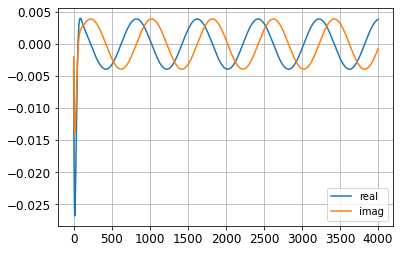

In [71]:
plt.plot(state_H.real, label='real')
plt.plot(state_H.imag, label='imag')
plt.grid()
plt.legend()

In [39]:
1-np.cos(np.pi/2/N)

3.0842355210336514e-05